# Le Debruiteur
* Jonas Freiburghaus
* Romain Capocasale
* He-Arc, INF3dlm-a
* Image Processing course
* 2019-2020

## Statistics

In [ ]:
from debruiteur.generator.datagenerator import DataGenerator
from debruiteur.plots.plots import *
from debruiteur.preprocessing.preprocessor import *
from debruiteur.noise.noise import *
from debruiteur.utils.utils import load_model, split_train_val_df
from debruiteur.noise.noisereduction import *
from debruiteur.statistics.statistics import * 
from debruiteur.metrics.metrics import *

In [ ]:
noise_class_list = [
    GaussianNoise(mean=0, std=10),
    PoissonNoise(),
    UniformNoise(amplitude=100),
    SaltPepperNoise(freq=0.3),
    SquareMaskNoise(mask_shape=(10, 10), freq=0.1),
    SpeckleNoise(),
    AveragingBlurNoise(),
    GaussianBlurNoise(),
    MedianBlurNoise()
]

### Load data

In [ ]:
working_dir = os.path.abspath(os.getcwd())

df_original = make_original_dataframe(os.path.join(working_dir, "images"))
df_resized = make_resized_dataframe(df_original, img_shape=(100, 100), resized_path=os.path.join(working_dir, "resized_images"))
df_noised = make_noised_dataframe(df_resized, noise_class_list, os.path.join(working_dir, "noised_images"))

### Metrics

Mean squared error (MSE) :
$$\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$$

Normalized root mean squared error (NRMSE) :
$$\text{NRMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n}\left(\log{\frac{\hat{y} + 1}{y + 1}}\right)^2}$$

Peak signal to noise ration (PSNR) :
$$\text{PSNR} = 10 \dot \log_{10} \left( \frac{{MAX_{I}^2}}{MSE} \right)$$

Structural similarity (SSIM) :
$$\text{SSIM(x, y)} = \frac{(2\mu_x \mu_y + c_1)(2\sigma_{xy} + c_2)}{(\mu_x^2 + \mu_y^2 + c_1)(\sigma_x^2 + \sigma_y^2 + c_2)}$$

### Show metrics example

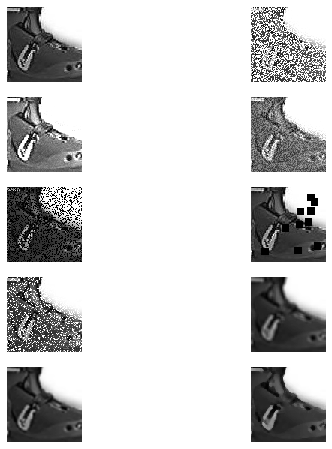

,Noise,MSE,NRMSE,PSNR,SSIM
0,GaussianNoise,13645.4937,0.860252,6.780911,0.246437
1,PoissonNoise,3254.8026,0.420139,13.005557,0.637884
2,UniformNoise,2534.7930,0.370768,14.091379,0.433237
3,SaltPepperNoise,5382.6398,0.540292,10.820850,0.269887
4,SquareMaskNoise,2967.9762,0.401200,13.406199,0.845506
5,SpeckleNoise,5258.6949,0.534035,10.922024,0.381281
6,AveragingBlurNoise,362.0518,0.140125,22.543096,0.718018
7,GaussianBlurNoise,190.2272,0.101570,25.338077,0.831002
8,MedianBlurNoise,265.8511,0.120074,23.884419,0.766049


In [7]:
metrics_example(df_noised, noise_class_list)

### Create data generator

In [ ]:
stats_gen = DataGenerator(df_noised[0:20], batch_size=20)

### Load models

In [ ]:
conv_ae_model = load_model(os.path.join(working_dir, "saved_models"), "conv_autoencoder.h5")
dense_ae_model = load_model(os.path.join(working_dir, "saved_models"), "dense_autoencoder.h5")
gan_model = load_model(os.path.join(working_dir, "saved_models"), "gan_generator.h5")

### Noise reduction methods

In [ ]:
noise_reduction_methods = [('Wiener Filter', wiener_filter),
                   ('Laplacian Filter', laplacian_filter),
                   ('Gaussian Weighted Filter', gaussian_weighted_substract_filter),
                   ('Mean Filter', mean_filter),
                   ('Median Filter', median_filter),
                   ('Conservative Filter', conservative_filter),
                   ('FFT FIlter', fft_filter),
                   ('Convolutional Autoencoder', lambda x : conv_ae_model.predict(x.reshape((1,100,100,1)))),
                   ('Dense Autoencoder', lambda x : dense_ae_model.predict(x.reshape((1, 10000)))),
                   ('Generative Adversarial Network', lambda x : gan_model.predict(x.reshape((1,100,100,1))))]

### Noise reduction methods metrics

In [ ]:
compute_noise_reduction_method_statistics(stats_gen, noise_reduction_methods)

### Noise reductions methods for each noise type

In [ ]:
compute_noise_type_statistics(stats_gen, noise_reduction_methods, noise_class_list, "SSIM")